In [1]:
import os
from tqdm import tqdm 
from utils import EXP_ROOT, load_jsonl, load_jsonl_iteratively

eval_qa_root = os.path.join(EXP_ROOT, "datasets/kg-datasets/ja-0.5/eval_qa")

# lang = "en"
# docs = load_jsonl(os.path.join(eval_qa_root, "01_fact_check/bionlp_ners.jsonl"))

lang = "ja"
docs = load_jsonl(os.path.join(eval_qa_root, "01_fact_check/ja_ners.jsonl"))


docs = {doc['docid']: doc for doc in docs}
model2triples = {}
# for model in ["Qwen3-32B", "Llama3.3-70B", "DeepSeek-R1-70B"]:
for model in ["Qwen3-32B", "llm-jp-3.1", "Swallow-70B"]:
    items = {}
    for item in load_jsonl_iteratively(os.path.join(eval_qa_root, f"02_triple_extract/{lang}_{model}.jsonl")):
        items[item['request_id']] = item
    model2triples[model] = items


# for model in ["Qwen3-32B", "Llama3.3-70B", "DeepSeek-R1-70B"]:
for model in ["Qwen3-32B", "llm-jp-3.1", "Swallow-70B"]:
    request_ids = set(model2triples[model].keys())
    merged_ids = request_ids if "merged_ids" not in locals() else merged_ids.intersection(request_ids)

print(f"Number of merged request_ids: {len(merged_ids)}")

import math

probs = []
fact_scores = {}
for request_id in merged_ids:
    fact_score = 0
    true_prob = 0
    
    for model in model2triples:
        prob = math.exp(model2triples[model][request_id]['logprob'])
        factuality = model2triples[model][request_id]['factuality']
        if factuality:
            fact_score += 1
            true_prob += prob

    fact_scores[request_id] = (fact_score, true_prob)
    probs.append(true_prob)
sorted_reqids = sorted(fact_scores, key=lambda x: fact_scores[x][1], reverse=True)


Number of merged request_ids: 34591


In [4]:
## English processing

def entity_bimatch(target_entity, cand_entities):
    for entity in cand_entities:
        if entity in target_entity or target_entity in entity:
            return True
    return False

extract_triples = []
for req_id in tqdm(sorted_reqids):
    if fact_scores[req_id][0] <= 2:
        continue
    
    docid, sentid = req_id.split("_sentid:")
    triples = []
    for model in model2triples:
        triple = model2triples[model][req_id]['triple']
        if triple is None:
            continue
        subj_cuis = []
        obj_cuis = []
        try:
            for entity in docs[docid]['sentences'][int(sentid)]['entities']:
                ent_aliases = [entity['text'].strip().lower()]
                for ent in entity['ents']:
                    if ent['score']  < 0.6:
                        continue        
                    ent_aliases.extend([alias.strip().lower() for alias in ent["aliases"]])
                
                # if not isinstance(triple['subject'], str) or not isinstance(triple['object'], str):
                #     print(f"Skipping triple with non-string subject or object: {triple}")
                #     continue

                    if entity_bimatch(triple['subject'].strip().lower(), ent_aliases):
                        subj_cuis.extend([(ent['cui'], entity['text']) for ent in entity['ents']])
                    if entity_bimatch(triple['object'].strip().lower(), ent_aliases):
                        obj_cuis.extend([(ent['cui'], entity['text']) for ent in entity['ents']])
            
            triples.append({
                "model": model,
                "subj": triple['subject'],
                "obj": triple['object'],
                "relation": model2triples[model][req_id]['triple']['relation'],
                # "subj_cuis": subj_cuis,
                # "obj_cuis": obj_cuis,
                "prob": math.exp(model2triples[model][req_id]['logprob'])
            })
        except Exception as e:
            print(f"Error processing entity matching: {e}")
            continue    
    
        
    item = {
        "request_id": req_id,
        "docid": docid,
        "sentid": sentid,
        "abstract": docs[docid]['abstract'],
        "sentence": docs[docid]['sentences'][int(sentid)]['text'],
        "triple": triples,
    }
    extract_triples.append(item)

  4%|▍         | 1579/40760 [00:00<00:07, 5229.77it/s]

Error processing entity matching: 'list' object has no attribute 'strip'
Error processing entity matching: 'list' object has no attribute 'strip'


  8%|▊         | 3156/40760 [00:00<00:07, 5097.85it/s]

Error processing entity matching: 'subject'
Error processing entity matching: 'list' object has no attribute 'strip'
Error processing entity matching: 'dict' object has no attribute 'strip'


 10%|█         | 4257/40760 [00:00<00:06, 5326.29it/s]

Error processing entity matching: 'NoneType' object has no attribute 'strip'
Error processing entity matching: 'list' object has no attribute 'strip'
Error processing entity matching: 'relation'
Error processing entity matching: 'relation'
Error processing entity matching: 'relation'
Error processing entity matching: 'object'


100%|██████████| 40760/40760 [00:00<00:00, 43257.67it/s]

Error processing entity matching: 'NoneType' object has no attribute 'strip'


In [24]:
## Japanese processing
extracted_triples = []
for req_id in tqdm(sorted_reqids):
    if fact_scores[req_id][0] <= 2:
        continue
    
    docid, sentid = req_id.split("_sentid:")
    triples = []
    for model in model2triples:
        triple = model2triples[model][req_id]['triple']
        if triple is None:
            continue
        try:
            triples.append({
                "model": model,
                "subj": triple['subject'],
                "obj": triple['object'],
                "relation": model2triples[model][req_id]['triple']['relation'],
                "prob": math.exp(model2triples[model][req_id]['logprob'])
            })
        except Exception as e:
            continue
    
        
    item = {
        "request_id": req_id,
        "docid": docid,
        "sentid": sentid,
        "abstract": docs[docid]['abstract'],
        "sentence": docs[docid]['sentences'][int(sentid)]['text'],
        "triple": triples,
    }
    extracted_triples.append(item)
    

100%|██████████| 34591/34591 [00:00<00:00, 418559.18it/s]


0.1134977306235726 3926


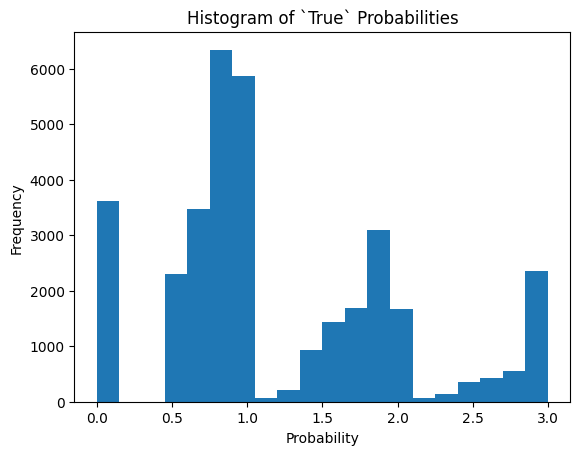

In [4]:
# Draw the histogram of probabilities
import matplotlib.pyplot as plt

lt2 = [prob>2 for prob in probs]
print(sum(lt2)/len(lt2), sum(lt2))
plt.hist(probs, bins=20)
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Histogram of `True` Probabilities")
plt.show()

In [ ]:
import os
import datetime
from openai import AzureOpenAI
    

os.environ["AZURE_OPENAI_API_KEY"] = "<API_KEY>"
# os.environ["AZURE_MODEL_NAME"] = "gpt-4o-mini-2024-07-18"
# os.environ["AZURE_API_VERSION"] = "2025-01-01-preview"
os.environ["AZURE_MODEL_NAME"] = "gpt-4.1-mini-2025-04-14"
os.environ["AZURE_API_VERSION"] = "2025-04-01-preview"
# os.environ["AZURE_OPENAI_ENDPOINT"] = "https://llm-jp-openai-mmwg-01.openai.azure.com/"
os.environ["AZURE_OPENAI_ENDPOINT"] = f"https://llm-jp-openai-mmwg-01.openai.azure.com/openai/deployments/{os.environ['AZURE_MODEL_NAME']}"

# client = AzureOpenAI(
#     api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
#     api_version=os.getenv("AZURE_API_VERSION"),
#     azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
#     )

In [ ]:
import json
import spacy
import requests
from utils import load_json

instructions = load_json("./instructions.json")
system_prompt = instructions["generate-qa"][lang]['system']
user_template = instructions["generate-qa"][lang]['user']

batch_requests = []
openai_requests = []
count = 0

def count_match_word_ratio(sentence_lemmas, entity_lemmas):
    entity_lemmas = set(entity_lemmas)
    match_count = len(entity_lemmas.intersection(sentence_lemmas))
    return match_count / len(entity_lemmas) if entity_lemmas else 0


if lang == "en":
    en_nlp = spacy.load("en_core_web_sm")
    ja_nlp = None
else:
    en_nlp = None
    ja_nlp = spacy.load("ja_core_news_sm")
print("Language:", lang)

/home/xzhao/.pyenv/versions/adaxeval/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Language: ja


In [ ]:
ja_no_qwen_triples = []
for request_item in tqdm(extracted_triples):
    if lang == "en":
        triples = request_item['triple']
        cand_triples = []
        for triple in triples:
            triple['subj_lemmas'] = [token.lemma_ for token in en_nlp(triple['subj'])]
            triple['obj_lemmas'] = [token.lemma_ for token in en_nlp(triple['obj'])]
            all_lemmas = triple['subj_lemmas'] + triple['obj_lemmas']
            sentence_lemmas = [token.lemma_ for token in en_nlp(request_item['sentence'])]
            match_ratio = count_match_word_ratio(sentence_lemmas, all_lemmas)
            triple['match_ratio'] = match_ratio
            if match_ratio < 0.5:
                continue
            cand_triples.append(triple)
        
        if len(cand_triples) == 0:
            cand_triples = triples

        # print(f"\n========== Request ID: {extract_triples[i]['request_id']} =========")
        min_len = 99999
        for item in cand_triples:
            length = len(item['subj_lemmas']) + len(item['obj_lemmas'])
            length = length * (1/item['match_ratio'])
            if length < min_len:
                min_len = length
                triple = item
        request_item['best_triple'] = triple    
        input_dict = {
            "sentences": request_item['sentence'],
            "triple": {
                "subject": request_item['best_triple']['subj'],
                "relation": request_item['best_triple']['relation'],
                "object": request_item['best_triple']['obj']
            }
        }
    elif lang == "ja":
        refind = False
        qwen_in = False
        cand_triples = []
        for item in request_item['triple']:
            try:
                item['subj_lemmas'] = [token.text for token in ja_nlp(item['subj'])]
                item['obj_lemmas'] = [token.text for token in ja_nlp(item['obj'])]
                all_lemmas = item['subj_lemmas'] + item['obj_lemmas']
                sentence_lemmas = [token.text for token in ja_nlp(request_item['sentence'])]
                match_ratio = count_match_word_ratio(sentence_lemmas, all_lemmas)
                item['match_ratio'] = match_ratio
                if match_ratio >= 0.5:
                    cand_triples.append(item)
            except Exception as e:
                refind = True
                continue
        
        for item in cand_triples:
            if item["model"] == "Qwen3-32B":
                best_triple = item
                qwen_in = True
                break
            
        if not qwen_in:
            ja_no_qwen_triples.append(request_item)
            min_len = 99999
            for item in cand_triples:
                if 'match_ratio' not in item:
                    continue
                if item['match_ratio'] == 0:
                    continue

                length = len(item['subj_lemmas']) + len(item['obj_lemmas'])
                length = length * (1/item['match_ratio'])
                if length < min_len:
                    min_len = length
                    best_triple = item

        request_item["best_triple"] = best_triple
        
        input_dict = {
            "sentences": request_item['sentence'],
            "triple": {
                "subject": best_triple['subj'],
                "relation": best_triple['relation'],
                "object": best_triple['obj']
            }
        }

    user_prompt = user_template.format(input=json.dumps(input_dict, ensure_ascii=False, indent=4))
    openai_requests.append({
        "request_id": request_item['request_id'],
        "message": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        "metadata": {
            "input": input_dict,
            "docid": request_item['docid'],
            "sentid": request_item['sentid'],
            "abstract": request_item['abstract'],
            "sentence": request_item['sentence']
        }})

print("Number of requests with no Qwen triples:", len(ja_no_qwen_triples))

100%|██████████| 3934/3934 [03:18<00:00, 19.86it/s]

Number of requests with no Qwen triples: 511


In [71]:
from utils import dump_jsonl

failed_openai_requests = []
for request_item in tqdm(ja_no_qwen_triples):
    user_prompt = user_template.format(input=json.dumps(input_dict, ensure_ascii=False, indent=4))
    failed_openai_requests.append({
        "request_id": request_item['request_id'],
        "message": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        "metadata": {
            "input": input_dict,
            "docid": request_item['docid'],
            "sentid": request_item['sentid'],
            "abstract": request_item['abstract'],
            "sentence": request_item['sentence']
        }})

qa_root = os.path.join(EXP_ROOT, "datasets/kg-datasets/ja-0.5/eval_qa/03_en_qa")
dump_file = os.path.join(qa_root, f"ja_requests.failed.jsonl")
dump_jsonl(failed_openai_requests, dump_file)

100%|██████████| 511/511 [00:00<00:00, 41078.86it/s]

In [ ]:
idx = 17
ja_no_qwen_triples[idx]['sentence'], ja_no_qwen_triples[idx]['best_triple']

In [24]:
print(openai_requests[0][1])

### Instruction: 
Given a biomedical sentence and its associated knowledge triple, follow the steps below to generate a multiple-choice question:

1. Generate a Fill-in-the-Blank Prompt: Create a fill-in-the-blank prompt for the triple by using the subject and relation as context, placing the object at the end as [BLANK]. Do not largely modify the original sentence, but ensure it is grammatically correct and clear. The prompt should be a complete sentence that can stand alone.
2. Generate Distractors: Create three plausible but incorrect choices (distractors). Each distractor should:
    - Be similar in length and semantic category to the correct object
    - Be clearly incorrect but not obviously so
3. Paraphrase into a Question: Rephrase the fill-in-the-blank prompt into a well-formed, self-contained question that asks for the object.
    - Use diverse vocabulary and a different linguistic style or structure than the original sentence. Avoid simply rearranging the original
    - Do n

In [ ]:
from langchain_openai import AzureChatOpenAI

os.environ["OPENAI_API_TYPE"] = "azure_ad"
os.environ["OPENAI_API_VERSION"] = "2025-04-01-preview"
os.environ["AZURE_OPENAI_API_KEY"] = "<API_KEY>"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://llm-jp-openai-mmwg-01.openai.azure.com"



# print(os.environ["AZURE_OPENAI_ENDPOINT"])
CONCURRENCY = 1

llm = AzureChatOpenAI(
        deployment_name=os.environ["AZURE_MODEL_NAME"],
        temperature=0,
        top_p=1,
        max_retries=1,
        timeout=120,
        logprobs=True,
        max_tokens=1024,
    )


In [50]:
print(user_prompt)

### Input:
```json
{
    "sentences": "The number of patients with malignant pleural mesothelioma who cannot undergo active treatment due to an older age or the presence of severe comorbidities is increasing.",
    "triple": {
        "subject": "Vitamin D supplementation",
        "relation": "reduces risk of",
        "object": "osteoporosis in elderly patients"
    }
}
```



[{'role': 'system',
  'content': '### Instruction: \nGiven a biomedical sentence and its associated knowledge triple, follow the steps below to generate a multiple-choice question:\n\n1. Generate a Fill-in-the-Blank Prompt: Create a fill-in-the-blank prompt for the triple by using the subject and relation as context, placing the object at the end as [BLANK]. Do not largely modify the original sentence, but ensure it is grammatically correct and clear. The prompt should be a complete sentence that can stand alone.\n2. Generate Distractors: Create three plausible but incorrect choices (distractors). Each distractor should:\n    - Be similar in length and semantic category to the given object, please ensure they are not too short or too long compared to the object.\n    - Be relevant to the subject and relation, but not the correct answer.\n3. Paraphrase into a Question: Rephrase the fill-in-the-blank prompt into a well-formed, self-contained question that asks for the object.\n    - Use 

In [ ]:

message = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_prompt}
]

response = llm.invoke(message)


In [60]:
print(openai_requests[0][1][1]["content"])


### Input:
```json
{
    "sentences": "Primary treatment of malignant melanoma is a wide range excision of the tumor lesion and its surrounding normal tissue.",
    "triple": {
        "subject": "Primary treatment of malignant melanoma",
        "relation": "is",
        "object": "wide range excision of the tumor lesion and its surrounding normal tissue"
    }
}
```



In [28]:
import asyncio
from agent_utils import adaptive_batch_process


responses = asyncio.run(
    adaptive_batch_process(
        llm, openai_requests, 
        dump_file="./test_responses.jsonl", 
        process_request_func=lambda x: x,
        start_concurrency=1, max_concurrency=5, step=2,
        failed_log_file="./test_failed.log",
        do_resample=False)
)


RuntimeError: asyncio.run() cannot be called from a running event loop

In [13]:
from utils import dump_jsonl


dump_jsonl(requests[:10], "./test.jsonl")

In [14]:
# Upload a file with a purpose of "batch"
file = client.files.create(
  file=open("/home/xzhao/workspace/roman-pretrain/datasets/generate_eval/test.jsonl", "rb"), 
  purpose="batch",
  extra_body={"expires_after":{"seconds": 1209600, "anchor": "created_at"}} # Optional you can set to a number between 1209600-2592000. This is equivalent to 14-30 days
)


print(file.model_dump_json(indent=2))

print(f"File expiration: {datetime.fromtimestamp(file.expires_at) if file.expires_at is not None else 'Not set'}")

file_id = file.id

{
  "id": "file-db5794d2ad5e445bafdd2db505ae738c",
  "bytes": 38221,
  "created_at": 1751085907,
  "filename": "test.jsonl",
  "object": "file",
  "purpose": "batch",
  "status": "processed",
  "expires_at": null,
  "status_details": null
}
File expiration: Not set


In [15]:
# Submit a batch job with the file
batch_response = client.batches.create(
    input_file_id=file_id,
    endpoint="/chat/completions",
    completion_window="24h",
    extra_body={"output_expires_after":{"seconds": 1209600, "anchor": "created_at"}} # Optional you can set to a number between 1209600-2592000. This is equivalent to 14-30 days
)


# Save batch ID for later use
batch_id = batch_response.id

print(batch_response.model_dump_json(indent=2))

BadRequestError: Error code: 400 - {'errors': {'data': [{'code': 'invalid_request', 'message': "Invalid deployment SKU 'GlobalStandard'. The deployment SKU needs to be 'Global-Batch' or 'DataZone-Batch' for batch API requests. Learn more: https://aka.ms/aoai_batch/errors.", 'line': None, 'param': None}], 'object': 'list'}}

In [17]:

for request in requests:
    print(json.dumps(request))

{"custom_id": "haigan@@51/7/51_7_830_sentid:1", "method": "POST", "url": "/v1/chat/completions", "body": {"model": "gpt-4.1-mini", "messages": [{"role": "system", "content": "### Instruction: \nGiven a biomedical sentence and its associated knowledge triple, follow the steps below to generate a multiple-choice question:\n\n1. Generate a Fill-in-the-Blank Prompt: Create a fill-in-the-blank prompt for the triple by using the subject and relation as context, placing the object at the end as [BLANK]. Do not largely modify the original sentence, but ensure it is grammatically correct and clear. The prompt should be a complete sentence that can stand alone.\n2. Generate Distractors: Create three plausible but incorrect choices (distractors). Each distractor should:\n    - Be similar in length and semantic category to the correct object\n    - Be clearly incorrect but not obviously so\n3. Paraphrase into a Question: Rephrase the fill-in-the-blank prompt into a well-formed, self-contained ques

In [18]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import List


class QAItem(BaseModel):
    prompt: str = Field(..., description="The sentence with a [BLANK] to be filled in.")
    question: str = Field(..., description="A question derived from the prompt.")
    distractors: List[str] = Field(..., description="List of incorrect answer choices.")
    object: str = Field(..., description="The correct answer to the question.")

parser = PydanticOutputParser(pydantic_object=QAItem, include_raw=True, strict=False)

In [19]:
responses = load_jsonl('response.jsonl')

In [22]:
import random


for idx in range(10):
    # print(extract_triples[idx]['sentence'])
    # print(extract_triples[idx]['best_triple']['obj'])
    # print(responses[idx]['response']['body']['choices'][0]['message']['content'])
    # print("\n\n")

    response = responses[idx]['response']['body']['choices'][0]['message']['content']
    response = parser.parse(response)
    # correct_answer = extract_triples[idx]['best_triple']['obj']
    correct_answer = response.object
    options = [correct_answer] + response.distractors
    random.shuffle(options)
    
    print("\n\n")
    print(response.prompt)
    print(response.question)
    print(f"1. {options[0]}\n2. {options[1]}\n3. {options[2]}\n4. {options[3]}")
    
    print(f"\nCorrect answer: {correct_answer}")
    print(f"Original object: {extract_triples[idx]['best_triple']['obj']}")
    if correct_answer != extract_triples[idx]['best_triple']['obj']:
        print("==== Mismatch detected!")
    # print(extract_triples[idx]['best_triple']["subj"])
    # print(extract_triples[idx]['best_triple']["relation"])
    # print(extract_triples[idx]["sentence"])




Pulmonary epithelioid hemangioendothelioma (PEH) is characterized by [BLANK].
What cellular process defines pulmonary epithelioid hemangioendothelioma (PEH)?
1. the growth of vascular endothelial cells
2. the infiltration of lymphatic tissues
3. the accumulation of fibrous connective tissue
4. the proliferation of smooth muscle cells

Correct answer: the growth of vascular endothelial cells
Original object: the growth of vascular endothelial cells



The sentinel node (SN) is a good indicator of the [BLANK].
What does the sentinel node (SN) effectively indicate in cases of solid tumors?
1. size of the primary tumor
2. immune response to infection
3. metastatic status of regional lymph nodes in solid tumors
4. vascular supply to the lesion

Correct answer: metastatic status of regional lymph nodes in solid tumors
Original object: metastatic status of regional lymph nodes in solid tumors



Dexamethasone (DEX) is used to palliate symptoms of [BLANK].
Which condition's symptoms are all

In [ ]:
    
user_prompt = user_prompt.replace("{input}", json.dumps(question, ensure_ascii=False))
